In [15]:
import sys
import os

# 获取你的模型的路径
# 请注意，你需要将 'dataset_name' 和 'file_name' 替换为你的实际数据集名称和文件名称
model_path = 'D:/Ti/Py_mmWave_Roformer/rope_informer'
data_path = 'D:/Ti/Py_mmWave_Roformer/dataTotal.xlsx'

checkpoints = 'D:/Ti/Py_mmWave_Roformer/checkpoints/'
output_path = 'D:/Ti/Py_mmWave_Roformer/test_results/'

# 确保目录存在
os.makedirs(checkpoints, exist_ok=True)
os.makedirs(output_path, exist_ok=True)

# 将模型路径添加到sys.path
sys.path.append(os.path.dirname(model_path))


# 现在你可以导入你的模型了

In [16]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [17]:
print(sys.path)

['D:\\Ti\\Py_mmWave_Roformer', 'D:\\Pycharm\\PyCharm 2025.2.0.1\\plugins\\python-ce\\helpers\\pydev', 'D:\\Pycharm\\PyCharm 2025.2.0.1\\plugins\\python-ce\\helpers\\jupyter_debug', 'D:\\Ti\\Py_mmWave_Roformer\\.venv\\Scripts\\python313.zip', 'C:\\Users\\黄家成\\AppData\\Local\\Programs\\Python\\Python313\\DLLs', 'C:\\Users\\黄家成\\AppData\\Local\\Programs\\Python\\Python313\\Lib', 'C:\\Users\\黄家成\\AppData\\Local\\Programs\\Python\\Python313', 'D:\\Ti\\Py_mmWave_Roformer\\.venv', '', 'D:\\Ti\\Py_mmWave_Roformer\\.venv\\Lib\\site-packages', 'D:\\Ti\\Py_mmWave_Roformer\\.venv\\Lib\\site-packages\\win32', 'D:\\Ti\\Py_mmWave_Roformer\\.venv\\Lib\\site-packages\\win32\\lib', 'D:\\Ti\\Py_mmWave_Roformer\\.venv\\Lib\\site-packages\\Pythonwin', 'D:/Ti/Py_mmWave_Roformer', 'D:\\Ti\\Py_mmWave_Roformer\\rope_informer', 'D:\\Ti\\Py_mmWave_Roformer\\rope_informer', 'D:/Ti/Py_mmWave_Roformer', 'D:/Ti/Py_mmWave_Roformer']


In [18]:
pip install reformer_pytorch

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [19]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn import Transformer
from torch.optim import Adam
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

In [20]:

import pandas as pd
import numpy as np

# 为 NumPy 2.0 提供向后兼容性
if not hasattr(np, 'Inf'):
    np.Inf = np.inf

import argparse
import os
import torch
import sys

# 改成kaggle路径
#sys.path.append(os.path.dirname(__file__))

from rope_informer import Exp_Informer

parser = argparse.ArgumentParser(description='[Informer] Long Sequences Forecasting')

parser.add_argument('--model', type=str, required=False, default='informer',help='model of experiment, options: [informer]')
parser.add_argument('--data', type=str, required=False, default='Classification', help='data')
parser.add_argument('--root_path', type=str, default= data_path, help='root path of the data file')
parser.add_argument('--enc_in', type=int, default=1, help='encoder input size')
parser.add_argument('--d_model', type=int, default=16, help='dimension of model')
parser.add_argument('--d_ff', type=int, default=64, help='dimension of fcn')
parser.add_argument('--train_epochs', type=int, default=8, help='train epochs')
parser.add_argument('--batch_size', type=int, default=8, help='batch size of train input data')
parser.add_argument('--seq_len', type=int, default=15000, help='input sequence length of Informer encoder')
parser.add_argument('--output_path', type=str, default=output_path, help='test_results')
parser.add_argument('--checkpoints', type=str, default=checkpoints, help='location of model checkpoints')
parser.add_argument('--test_ratio', type=float,default=0.1, help='')
parser.add_argument('--n_heads', type=int, default=4, help='num of heads')
parser.add_argument('--has_rope', type=bool,default=True, help='')

# 以上参数为自定义，以下参数不可修改

parser.add_argument('--data_path', type=str, default='ETTh1.csv', help='data file')
parser.add_argument('--features', type=str, default='M', help='forecasting task, options:[M, S, MS]; M:multivariate predict multivariate, S:univariate predict univariate, MS:multivariate predict univariate')
parser.add_argument('--target', type=str, default='OT', help='target feature in S or MS task')
parser.add_argument('--freq', type=str, default='h', help='freq for time features encoding, options:[s:secondly, t:minutely, h:hourly, d:daily, b:business days, w:weekly, m:monthly], you can also use more detailed freq like 15min or 3h')
parser.add_argument('--label_len', type=int, default=48, help='start token length of Informer decoder')
parser.add_argument('--pred_len', type=int, default=24, help='prediction sequence length')
parser.add_argument('--dec_in', type=int, default=1, help='decoder input size')
parser.add_argument('--c_out', type=int, default=10, help='output size')
parser.add_argument('--e_layers', type=int, default=2, help='num of encoder layers')
parser.add_argument('--d_layers', type=int, default=1, help='num of decoder layers')
parser.add_argument('--s_layers', type=str, default='3,2,1', help='num of stack encoder layers')
parser.add_argument('--factor', type=int, default=5, help='probsparse attn factor')
parser.add_argument('--padding', type=int, default=0, help='padding type')
parser.add_argument('--distil', action='store_false', help='whether to use distilling in encoder, using this argument means not using distilling', default=True)
parser.add_argument('--dropout', type=float, default=0.05, help='dropout')
parser.add_argument('--attn', type=str, default='prob', help='attention used in encoder, options:[prob, full]')
parser.add_argument('--embed', type=str, default='timeF', help='time features encoding, options:[timeF, fixed, learned]')
parser.add_argument('--activation', type=str, default='gelu',help='activation')
parser.add_argument('--output_attention', action='store_true', help='whether to output attention in ecoder')
parser.add_argument('--do_predict', action='store_true', help='whether to predict unseen future data')
parser.add_argument('--mix', action='store_false', help='use mix attention in generative decoder', default=True)
parser.add_argument('--cols', type=str, nargs='+', help='certain cols from the data files as the input features')
parser.add_argument('--num_workers', type=int, default=0, help='data loader num workers')
parser.add_argument('--itr', type=int, default=1, help='experiments times')
parser.add_argument('--patience', type=int, default=2, help='early stopping patience')
parser.add_argument('--learning_rate', type=float, default=0.0001, help='optimizer learning rate')
parser.add_argument('--des', type=str, default='test',help='exp description')
parser.add_argument('--loss', type=str, default='mse',help='loss function')
parser.add_argument('--lradj', type=str, default='type1',help='adjust learning rate')
parser.add_argument('--use_amp', action='store_true', help='use automatic mixed precision training', default=False)
parser.add_argument('--inverse', action='store_true', help='inverse output data', default=False)
parser.add_argument('--use_gpu', type=bool, default=True, help='use gpu')
parser.add_argument('--gpu', type=int, default=0, help='gpu')
parser.add_argument('--use_multi_gpu', action='store_true', help='use multiple gpus', default=False)
parser.add_argument('--devices', type=str, default='0,1,2,3',help='device ids of multile gpus')

args = parser.parse_known_args()[0]

args.use_gpu = True if torch.cuda.is_available() and args.use_gpu else False

if args.use_gpu and args.use_multi_gpu:
    args.devices = args.devices.replace(' ','')
    device_ids = args.devices.split(',')
    args.device_ids = [int(id_) for id_ in device_ids]
    args.gpu = args.device_ids[0]

print('Args in experiment:')
print(args)

Exp = Exp_Informer
torch.manual_seed(111)
# for ii in range(args.itr):
    # setting record of experiments
setting = '{}_{}_ft{}_sl{}_ll{}_pl{}_dm{}_nh{}_el{}_dl{}_df{}_at{}_fc{}_eb{}_dt{}_mx{}_{}_{}'.format(args.model, args.data, args.features,
            args.seq_len, args.label_len, args.pred_len,
            args.d_model, args.n_heads, args.e_layers, args.d_layers, args.d_ff, args.attn, args.factor,
            args.embed, args.distil, args.mix, args.des, 1)

exp = Exp(args) # set experiments
print('>>>>>>>start training : {}>>>>>>>>>>>>>>>>>>>>>>>>>>'.format(setting))
exp.train(setting)

print('>>>>>>>testing : {}<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<'.format(setting))
exp.test(setting)

torch.cuda.empty_cache()


Args in experiment:
Namespace(model='informer', data='Classification', root_path='D:/Ti/Py_mmWave_Roformer/dataTotal.xlsx', enc_in=1, d_model=16, d_ff=64, train_epochs=8, batch_size=8, seq_len=15000, output_path='D:/Ti/Py_mmWave_Roformer/test_results/', checkpoints='D:/Ti/Py_mmWave_Roformer/checkpoints/', test_ratio=0.1, n_heads=4, has_rope=True, data_path='ETTh1.csv', features='M', target='OT', freq='h', label_len=48, pred_len=24, dec_in=1, c_out=10, e_layers=2, d_layers=1, s_layers='3,2,1', factor=5, padding=0, distil=True, dropout=0.05, attn='prob', embed='timeF', activation='gelu', output_attention=False, do_predict=False, mix=True, cols=None, num_workers=0, itr=1, patience=2, learning_rate=0.0001, des='test', loss='mse', lradj='type1', use_amp=False, inverse=False, use_gpu=False, gpu=0, use_multi_gpu=False, devices='0,1,2,3')
Use CPU
>>>>>>>start training : informer_Classification_ftM_sl15000_ll48_pl24_dm16_nh4_el2_dl1_df64_atprob_fc5_ebtimeF_dtTrue_mxTrue_test_1>>>>>>>>>>>>>>>>>>

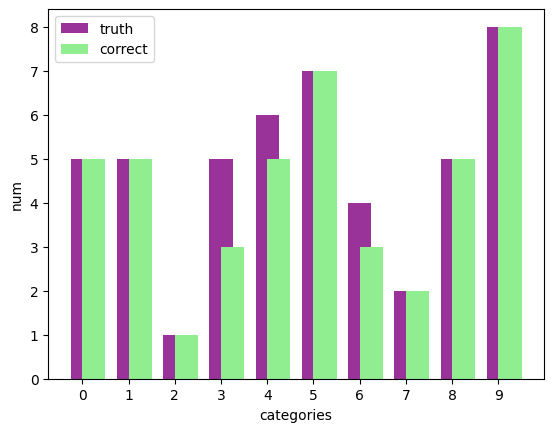

In [21]:
import matplotlib.pyplot as plt
import numpy as np
truth = np.load(os.path.join(args.output_path, setting,"true.npy"))
preds = np.load(os.path.join(args.output_path, setting,"pred.npy"))

# 计算每个类别的总数和预测正确的数量
bin_counts = np.bincount(truth, minlength=10)
correct_counts = np.bincount(truth[preds == truth], minlength=10)
# 绘制直方图
categories = range(10)
plt.bar(categories, bin_counts, width=0.5, align='center', alpha=0.8, label='truth',color = 'purple')
plt.bar(categories, correct_counts, width=0.5, align='edge', alpha=1.0, label='correct',color = 'lightgreen')
plt.xlabel('categories')
plt.ylabel('num')
plt.xticks(categories)
plt.legend()
# plt.show()
plt.savefig('D:/Ti/Py_mmWave_Roformer/graph.png')  # 保存到你的项目目录